# PROYECTO 2: Ingeniería de Features, Modelos Avanzados e Interpretación de Modelos

En esta sección, en el Sprint Project 1 volvimos a cargar los datos y realizamos un filtrado como especifica la consigna. En este nuevo proyecto, volveré a cargar los datos y basándome en el EDA que realicé, procederé con las transformaciones.
## TRANSFORMACIÓN DE DATOS
Antes de poder entrenar y probar modelos de machine learning debemos pre procesar los datos para que nuestros modelos funcionen de manera óptima. Hay diferentes tratamientos que se pueden hacer sobre los datos. En este caso aplicaremos los siguientes: imputación de valores faltantes (para evitar descartar información que podría resultar útil), detección y eliminación de outliers (para evitar que confundan al modelo con valores muy por fuera del rango de aprendizaje), encoding (para conservar variables categóricas que podrían servir al modelo) y finalmente escalado de datos (ya que los modelos no "entienden" de unidades, para delimitar bien los rangos que maneja cada variable y cuales son los valores esperables que puede tomar)

Cargaré los datos y comenzaré a filtrar de nuevo.
Lo primero que quiero hacer es eliminar las variables que no voy a usar, porque ya fueron exploradas en el EDA.

In [1]:
#IMPORTO LAS LIBRERÍAS NECESARIAS PARA TRABAJAR LOS DATOS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
df = df.loc[:,['lat', 'lon','l2','l3','rooms', 'bedrooms',
               'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type']]
df.head()

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,-34.605880,-58.384949,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,-34.624056,-58.412110,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,-34.593569,-58.427474,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,-34.581294,-58.436754,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,-34.914194,-57.938219,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH


A continuación también voy a filtrar por tipo de propiedad, dejando solo `PH`, `Casa` y `Departamento`, y por ubicación, dejando solo las propiedades en `Capital Federal`. El resto de las propiedades no representan un porcentaje significativo del dataset, y considero que generarían confusión en el modelo.

In [3]:
df = df[(df.property_type == 'Casa') | (df.property_type == 'Departamento') | (df.property_type == 'PH')]
df = df[df.l2 == 'Capital Federal']
df.drop(columns='l2', inplace=True)
new_index = np.arange(len(df.index))
df.index = new_index #reindexamos para poder iterar

### 1. VALORES FALTANTES
Observamos los valores faltantes para cada variable:

In [4]:
df.isna().sum()

lat                4534
lon                4548
l3                    0
rooms                 0
bedrooms              0
bathrooms          2171
surface_total      8917
surface_covered    9235
price                 0
property_type         0
dtype: int64

Podemos ver en el output de la celda anterior que tenemos valores faltantes para las variables `bathrooms`, `surface_total`, `surface_covered`, `lat` y `lon`. Ahora voy a investigar si son MAR MCAR O MNAR. Lo primero que quiero hacer es agruparlos por tipo y ver si esos valores faltantes dependen de otra variable.

In [5]:
print('Proporción de valores faltantes en bathrooms por tipo de propiedad')
df['bathrooms'].isna().groupby(df['property_type']).sum()/df['property_type'].value_counts()

Proporción de valores faltantes en bathrooms por tipo de propiedad


Casa            0.054235
Departamento    0.024510
PH              0.009013
dtype: float64

Visualizamos los valores con los que podríamos imputar los datos faltantes. En este caso, como confirmamos que no dependen de la variable `property_type`, vamos a imputar por la moda correspondiente a cada tipo de propiedad.

In [6]:
filling_method = df[['bathrooms']].groupby(df['property_type']).agg(lambda x: x.mode())
filling_method

,bathrooms
property_type,
Casa,2.0
Departamento,1.0
PH,1.0


In [7]:
filling_method = filling_method.to_dict()

In [8]:
df = df.set_index('property_type')
df['bathrooms'] = df['bathrooms'].fillna(filling_method['bathrooms'])
df.reset_index(inplace=True)

In [9]:
df.isna().sum()

property_type         0
lat                4534
lon                4548
l3                    0
rooms                 0
bedrooms              0
bathrooms             0
surface_total      8917
surface_covered    9235
price                 0
dtype: int64

En el último output confirmamos que reemplazamos todos los faltantes.
Ahora vemos los valores faltantes de `surface_covered` y `surface_total`. En este caso, primero reemplazaré con los valores que si tengo (superficie total por cubierta y viceversa). Luego voy a tirar todas las filas con valores faltantes en ambas variables. Al ser un factor determinante del precio, imputar podría afectar seriamente el funcionamiento de nuestro modelo.

In [10]:
df.surface_covered.fillna(df.surface_total, inplace=True)
df.surface_total.fillna(df.surface_covered, inplace=True)
df.dropna(subset=['surface_covered','surface_total'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.isna().sum()

(82767, 10)


property_type         0
lat                4266
lon                4266
l3                    0
rooms                 0
bedrooms              0
bathrooms             0
surface_total         0
surface_covered       0
price                 0
dtype: int64

Como no voy a usar `lat` ni `lon` para el entrenamiento de los modelos, las voy a dejar con sus valores faltantes como están.

### 2.DETECCIÓN DE OUTLIERS
Primero modifico los valores de `surface_covered` para que tengan sentido.

**Nota:** hago el cálculo del promedio y la desviación estándar con el dataframe original `df` y filtro en una nueva variable `data`. Es para que el filtrado de variables anteriores no me afecte el cáculo de los estadísticos y no perder más datos de los necesarios.

In [11]:
for n in np.arange(len(df.index)):
    if df.at[n,'surface_covered'] > df.at[n,'surface_total']:
        df.at[n,'surface_covered'] = df.at[n,'surface_total']
    else:
        None

Ahora si comenzaré con la detección de outliers. Voy a utilizar la regla de las 3 sigmas para todas las variables. 
* `price`

In [12]:
mean = df.price.mean()
std = df.price.std()
minimo = mean - (3*std)
maximo = mean + (3*std)
data = df[(df.price > minimo) & (df.price < maximo)]
print(mean,std,maximo,minimo)

264883.03728539153 332045.0739178204 1261018.2590388528 -731252.1844680698


* `surface_total`

In [13]:
mean = df.surface_total.mean()
std = df.surface_total.std()
minimo = mean - (3*std)
maximo = mean + (3*std)
data = data[(data.surface_total > minimo) & (data.surface_total < maximo)]
print(mean,std,maximo,minimo)

112.50611958872497 979.5471443781937 3051.1475527233065 -2826.135313545856


* `surface_covered`

In [14]:
mean = df.surface_covered.mean()
std = df.surface_covered.std()
minimo = mean - (3*std)
maximo = mean + (3*std)
data = data[(data.surface_covered > minimo) & (data.surface_covered < maximo)]
print(mean,std,maximo,minimo)

92.2154602679812 763.050881012027 2381.368103304062 -2196.9371827681


* `rooms`

In [15]:
mean = df.rooms.mean()
std = df.rooms.std()
minimo = mean - (3*std)
maximo = mean + (3*std)
data = data[(data.rooms > minimo) & (data.rooms < maximo)]
print(mean,std,maximo,minimo)

3.0074788261021905 1.3105884766285103 6.939244255987722 -0.9242866037833406


* `bedrooms`

In [16]:
mean = df.bedrooms.mean()
std = df.bedrooms.std()
minimo = mean - (3*std)
maximo = mean + (3*std)
data = data[(data.bedrooms > minimo) & (data.bedrooms < maximo)]
print(mean,std,maximo,minimo)

2.0007974192613 1.0521291074428885 5.157184741589965 -1.1555899030673658


* `bathrooms` 

In [17]:
mean = df.bathrooms.mean()
std = df.bathrooms.std()
minimo = mean - (3*std)
maximo = mean + (3*std)
data = data[(data.bathrooms > minimo) & (data.bathrooms < maximo)]
data.reset_index(drop=True, inplace=True)
print(mean,std,maximo,minimo)

1.5490594077349669 0.8524138005257934 4.106300809312347 -1.0081819938424132


Así nos quedan los `boxplots` después del filtrado:

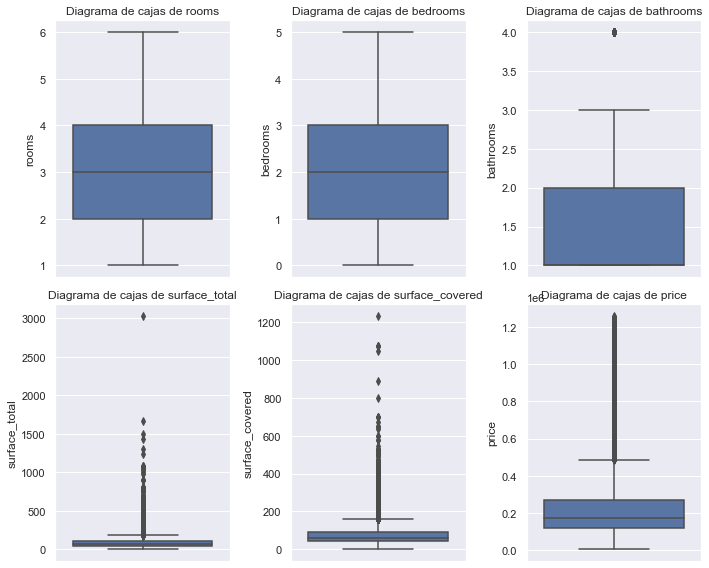

In [18]:
plt.figure(figsize=(10,12))
for idx,col in enumerate(data.drop(columns=['l3','property_type','lat','lon']).columns):
    plt.subplot(3,3,idx+1)
    sns.boxplot(y=data[col])
    plt.ylabel(str(col))
    plt.title(f'Diagrama de cajas de {str(col)}')
    
plt.tight_layout()

Si bien algunos diagramas quedaron algo "aplastados", en especial `surface_total` y `surface_covered`, estoy conforme con estos resultados. Al tener distintos tipos de propiedades, las variables de superficie pueden estar más dispersas.

### 3.ENCODING (PARTE 1)

Vamos a codificar la variable `l3` de manera ordinal usando el valor por metro cuadrado.

In [19]:
data['m2'] = data['price'] / data['surface_total']
data

,property_type,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,m2
0,PH,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,2271.428571
1,PH,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,2777.777778
2,PH,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,3470.588235
3,PH,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,2678.571429
4,PH,-34.600988,-58.433061,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,2278.571429
...,...,...,...,...,...,...,...,...,...,...,...
79755,Departamento,-34.581308,-58.431236,Palermo,4.0,3.0,2.0,106.0,100.0,620000.0,5849.056604
79756,PH,-34.585355,-58.427194,Palermo,4.0,3.0,3.0,175.0,111.0,570000.0,3257.142857
79757,PH,-34.585355,-58.427194,Palermo,3.0,2.0,2.0,144.0,134.0,480000.0,3333.333333
79758,PH,-34.584134,-58.436389,Palermo,4.0,2.0,2.0,317.0,143.0,530000.0,1671.924290


In [20]:
dicc = data[['m2']].groupby(data['l3']).mean()
dicc

,m2
l3,
Abasto,2401.671112
Agronomía,3544.676294
Almagro,2563.935102
Balvanera,2065.321797
Barracas,2210.015326
Barrio Norte,3106.661017
Belgrano,3320.754842
Boca,1740.101811
Boedo,2063.524940


In [21]:
dicc.to_dict()

{'m2': {'Abasto': 2401.671112071964,
  'Agronomía': 3544.6762938732563,
  'Almagro': 2563.9351015375046,
  'Balvanera': 2065.32179672534,
  'Barracas': 2210.0153255018145,
  'Barrio Norte': 3106.6610171107877,
  'Belgrano': 3320.7548419700856,
  'Boca': 1740.1018108101248,
  'Boedo': 2063.524940126386,
  'Caballito': 2661.6303576015343,
  'Catalinas': 2040.9733736118492,
  'Centro / Microcentro': 2311.5395077124026,
  'Chacarita': 2424.7338540387914,
  'Coghlan': 2738.1623329184918,
  'Colegiales': 2690.408720334767,
  'Congreso': 2126.2405176195084,
  'Constitución': 1646.461876017757,
  'Flores': 2043.0239510650895,
  'Floresta': 1771.9071753223675,
  'Las Cañitas': 3715.905769054533,
  'Liniers': 2015.7250322874108,
  'Mataderos': 1696.449647573033,
  'Monserrat': 2044.3395998458493,
  'Monte Castro': 2027.2147440429626,
  'Nuñez': 3191.3621335494904,
  'Once': 1970.6310411049,
  'Palermo': 3352.064528090818,
  'Parque Avellaneda': 1504.8396552150366,
  'Parque Centenario': 2441.808

In [22]:
data['l3'] = data['l3'].replace(to_replace=dicc['m2'])
data.drop(columns=['m2'], inplace=True)
data

,property_type,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
0,PH,-34.624056,-58.412110,2063.524940,2.0,1.0,2.0,70.0,58.0,159000.0
1,PH,-34.593569,-58.427474,3352.064528,2.0,1.0,1.0,45.0,45.0,125000.0
2,PH,-34.581294,-58.436754,3352.064528,2.0,1.0,1.0,85.0,50.0,295000.0
3,PH,-34.593779,-58.441239,2433.929220,2.0,1.0,1.0,56.0,56.0,150000.0
4,PH,-34.600988,-58.433061,2433.929220,2.0,1.0,1.0,70.0,70.0,159500.0
...,...,...,...,...,...,...,...,...,...,...
79755,Departamento,-34.581308,-58.431236,3352.064528,4.0,3.0,2.0,106.0,100.0,620000.0
79756,PH,-34.585355,-58.427194,3352.064528,4.0,3.0,3.0,175.0,111.0,570000.0
79757,PH,-34.585355,-58.427194,3352.064528,3.0,2.0,2.0,144.0,134.0,480000.0
79758,PH,-34.584134,-58.436389,3352.064528,4.0,2.0,2.0,317.0,143.0,530000.0


En el bloque de código anterior lo que hice fue sacar el promedio del precio por metro cuadrado para cada barrio que tenemos en el dataset, para poder indicarle al modelo de esta forma qué barrios son más caros y en qué medida.
### 4. ESCALADO DE DATOS
A continuación vamos a escalar los datos para las 7 variables numéricas que conservamos en el dataset (incluyendo la que acabamos de codificar)

In [23]:
from sklearn.preprocessing import StandardScaler

* `surface_total`

In [24]:
scaler = StandardScaler()
scaler.fit(data[['surface_total']])
data['surface_total'] = scaler.transform(data[['surface_total']])

* `surface_covered`

In [25]:
scaler = StandardScaler()
scaler.fit(data[['surface_covered']])
data['surface_covered'] = scaler.transform(data[['surface_covered']])

* `rooms`

In [26]:
scaler = StandardScaler()
scaler.fit(data[['rooms']])
data['rooms'] = scaler.transform(data[['rooms']])

* `bedrooms`

In [27]:
scaler = StandardScaler()
scaler.fit(data[['bedrooms']])
data['bedrooms'] = scaler.transform(data[['bedrooms']])

* `bathrooms`

In [28]:
scaler = StandardScaler()
scaler.fit(data[['bathrooms']])
data['bathrooms'] = scaler.transform(data[['bathrooms']])

* `l3`

In [29]:
scaler = StandardScaler()
scaler.fit(data[['l3']])
data['l3'] = scaler.transform(data[['l3']])

### 5. ENCODING (PARTE 2)
Empezamos con ONE HOT ENCODING para la variable `property_type`.

In [30]:
data['Casa'] = data[data['property_type']=='Casa']['property_type']
data['Departamento'] = data[data['property_type']=='Departamento']['property_type']
data['PH'] = data[data['property_type']=='PH']['property_type']
data['Casa'].replace(to_replace='Casa', value= 1, inplace=True)
data['Departamento'].replace(to_replace='Departamento', value= 1, inplace=True)
data['PH'].replace(to_replace='PH', value= 1, inplace=True)
data['Casa'].fillna(0, inplace=True)
data['Departamento'].fillna(0, inplace=True)
data['PH'].fillna(0, inplace=True)
data.drop(columns=['property_type'], inplace=True)
data

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH
0,-34.624056,-58.412110,-1.073827,-0.806076,-0.995349,0.733311,-0.275060,-0.359579,159000.0,0.0,0.0,1.0
1,-34.593569,-58.427474,0.776821,-0.806076,-0.995349,-0.660078,-0.662837,-0.626306,125000.0,0.0,0.0,1.0
2,-34.581294,-58.436754,0.776821,-0.806076,-0.995349,-0.660078,-0.042393,-0.523719,295000.0,0.0,0.0,1.0
3,-34.593779,-58.441239,-0.541839,-0.806076,-0.995349,-0.660078,-0.492215,-0.400614,150000.0,0.0,0.0,1.0
4,-34.600988,-58.433061,-0.541839,-0.806076,-0.995349,-0.660078,-0.275060,-0.113368,159500.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
79755,-34.581308,-58.431236,0.776821,0.999162,1.168813,0.733311,0.283340,0.502157,620000.0,0.0,1.0,0.0
79756,-34.585355,-58.427194,0.776821,0.999162,1.168813,2.126701,1.353605,0.727850,570000.0,0.0,0.0,1.0
79757,-34.585355,-58.427194,0.776821,0.096543,0.086732,0.733311,0.872761,1.199753,480000.0,0.0,0.0,1.0
79758,-34.584134,-58.436389,0.776821,0.999162,0.086732,0.733311,3.556179,1.384411,530000.0,0.0,0.0,1.0


Hasta aquí llegamos con el preprocesamiento del dataset. A continuación voy a plotear un mapa de color para visualizar cómo quedo el mapa de correlaciones antes de empezar con el modelado

<AxesSubplot:>

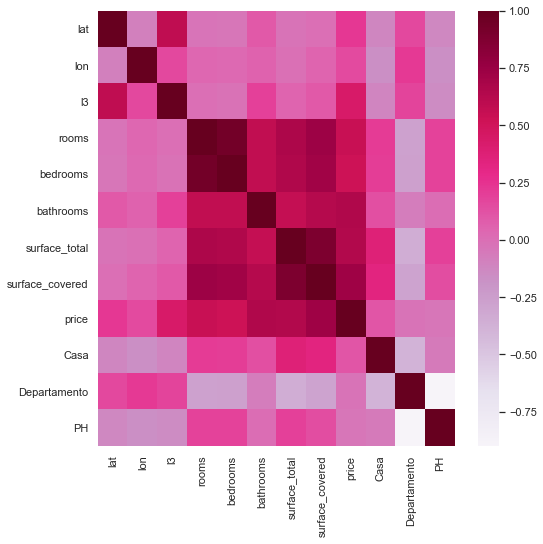

In [31]:
corr = data.corr()
plt.figure(figsize=(8,8))
sns.heatmap(data=corr, cmap='PuRd')

### REIMPLEMENTACIÓN DEL MODELO DEL PROYECTO 1
Con el dataset transformado volveré a elegir las variables de entrenamiento, entrenaré, implementaré y evaluaré el árbol de decisión del proyecto 1 (el cual optimicé a `max_depth = 8`).

In [32]:
##CELDA AUXILIAR PARA IMPORTAR
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor

In [33]:
X = data[['l3','rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered','Casa','Departamento','PH']]
y = data.price

Separamos variables de entrenamiento y testeo:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Creamos nuevamente el modelo elegido en el Proyecto 1, entrenamos y predecimos:

In [35]:
tree = DecisionTreeRegressor(max_depth=8)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

Ahora que ya tenemos el modelo entrenado y sus predicciones vamos a implementar las mismas métricas para evaluar el nuevo desempeño

In [36]:
print('El MAE para tree en test es: ', metrics.mean_absolute_error(y_test, y_test_pred))
print('El MAE para tree en train es: ', metrics.mean_absolute_error(y_train, y_train_pred))
print('El factor R2 para tree en test es: ', metrics.r2_score(y_test, y_test_pred))
print('El factor R2 para tree en train es: ', metrics.r2_score(y_train, y_train_pred))

El MAE para tree en test es:  41749.790764000085
El MAE para tree en train es:  40542.51885827746
El factor R2 para tree en test es:  0.820325996909079
El factor R2 para tree en train es:  0.837214861653137


Viendo el output de la última celda vemos que el MAE disminuyó casi 25000 dólares. Sin haber hecho una nueva optimización de hiperparámetros creo que es una mejora considerable. Creo que el trabajo con las nuevas técnicas de preprocesamiento hacen que el dataset sea mucho más "comprensible" para el modelo. De todas formas, sigue siendo un modelo muy simple, asique veamos que resultados tenemos probando algunos más avanzados.

## MODELOS AVANZADOS

Para esta sección voy a elegir Regresión Lineal (con atributos polinómicos) y un Random Forest Regressor. La regresión `Ridge` trabaja con una función de costo a reducir, regulada por el factor alpha. `RandomForestRegressor` es un modelo de *ensamble*, que consiste en la combinación de muchos modelos simples, con iteración tanto de features como de instancias para los entrenamientos de todos sus árboles.
### REGRESIÓN `Ridge` CON ATRIBUTOS POLINÓMICOS
* **ELECIÓN DE VARIABLES Y TRAIN TEST SPLIT**

Voy a volver a elegir variables y las separaré en train y test.

In [37]:
X = data[['surface_covered', 'l3', 'bathrooms']]
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

* **ATRIBUTOS POLINÓMICOS**

Creamos los atributos polinómicos para X

In [38]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

In [39]:
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.transform(X_test)

* **CREACIÓN DEL MODELO** 

Creamos el modelo con sus argumentos por defecto

In [40]:
from sklearn.linear_model import Ridge
reg = Ridge()
reg.fit(X_train_new, y_train)

Ridge()

* **PREDECIMOS**

In [41]:
y_test_pred = reg.predict(X_test_new)
y_train_pred = reg.predict(X_train_new)

* **EVALUAMOS**

In [42]:
print('El MAE para reg en test es: ', metrics.mean_absolute_error(y_test, y_test_pred))
print('El MAE para reg en train es: ', metrics.mean_absolute_error(y_train, y_train_pred))
print('El factor R2 para reg en test es: ', metrics.r2_score(y_test, y_test_pred))
print('El factor R2 para reg en train es: ', metrics.r2_score(y_train, y_train_pred))

El MAE para reg en test es:  47077.475521044704
El MAE para reg en train es:  47103.469324734266
El factor R2 para reg en test es:  0.7837484652627681
El factor R2 para reg en train es:  0.7779616192593817


Estos resultados preeliminares son ligeramente alentadores, teniendo en cuenta que todavía no hicimos optimización de hiperparámetros.
### OPTIMIZACIÓN DE HIPERPARÁMETROS
Lo siguiente será optimizar los hiperparámetros de nuestro modelo.
#### GRID SEARCH
Armamos la grilla para que el algoritmo busque los mejores hiperparámetros. Elijo `alpha` y `solver` porque son los que potencialmente podrían modificar el rendimiento, el resto no infieren en la performance del modelo.

In [43]:
param_grid = {'alpha':[0.01,0.025,0.05,0.075,0.1,0.25,0.5,0.75,1.0],
              'solver':['auto','svd','cholesky','lsqr','sag','saga']}

In [44]:
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(estimator=reg, param_grid=param_grid, n_jobs=-1, scoring='r2', cv=5)

In [45]:
model.fit(X_train_new, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5,
                                   0.75, 1.0],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag',
                                    'saga']},
             scoring='r2')

In [46]:
print('Los mejores hiperparámetros para el modelo son:', model.best_params_)

Los mejores hiperparámetros para el modelo son: {'alpha': 1.0, 'solver': 'auto'}


In [47]:
print('El puntaje R2 para el mejor modelo fue:', model.best_score_)

El puntaje R2 para el mejor modelo fue: 0.7768854754503641


A continuación haré una pequeña curva de validación para ver como evolucionan los puntajes en función de `alpha`

In [48]:
scores_train = []
scores_test = []
alphas = [0.01,0.025,0.05,0.075,0.1,0.25,0.5,0.75,1.0]
for alpha in alphas:
    reg = Ridge(alpha=alpha, random_state=42)
    reg.fit(X_train_new, y_train)
    
    y_pred_train = reg.predict(X_train_new)
    y_pred_test = reg.predict(X_test_new)
    
    scores_train.append(metrics.r2_score(y_train, y_pred_train))
    scores_test.append(metrics.r2_score(y_test, y_pred_test))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

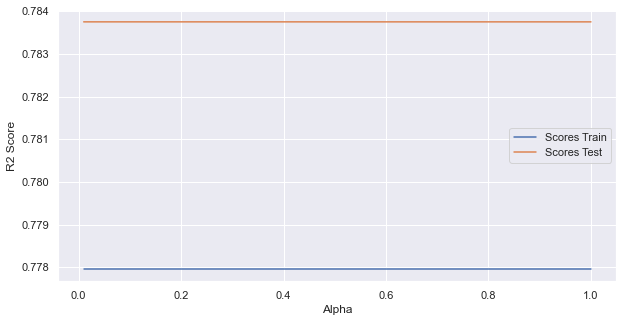

In [49]:
plt.figure(figsize=(10,5))
plt.plot(alphas,scores_train, label = 'Scores Train')
plt.plot(alphas,scores_test, label = 'Scores Test')
plt.legend()
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

Podemos ver el motivo por el cual la búsqueda por `GridSearchCV` nos dió como resultado los mismos hiperparámetros (por defecto). No se registra ninguna mejora en el modelo modificando `alpha`, como nos muestra el gráfico.

Ya definimos los mejores hiperparámetros para nuestro modelo de regresión lineal `Ridge` con atributos polinómicos, que nos da igual que los hiperparámetros por defecto. Usamos validación cruzada con 5 k-folds y la métrica `r2` para la evaluación del modelo.

### `RandomForestRegressor`
* **ELECIÓN DE VARIABLES Y TRAIN TEST SPLIT**

Como este modelo no se ve afectado negativamente por una gran cantidad de features, vamos a tomar todos

In [50]:
X = data[['l3','rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered','Casa','Departamento','PH']]
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

* **CREACIÓN DEL MODELO** 

Creamos el modelo con sus argumentos por defecto

In [51]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()

In [52]:
forest.fit(X_train, y_train)

RandomForestRegressor()

* **PREDECIMOS**

In [53]:
y_test_pred = forest.predict(X_test)
y_train_pred = forest.predict(X_train)

* **EVALUAMOS**

In [54]:
print('El MAE para forest en test es: ', metrics.mean_absolute_error(y_test, y_test_pred))
print('El MAE para forest en train es: ', metrics.mean_absolute_error(y_train, y_train_pred))
print('El factor R2 para forest en test es: ', metrics.r2_score(y_test, y_test_pred))
print('El factor R2 para forest en train es: ', metrics.r2_score(y_train, y_train_pred))

El MAE para forest en test es:  25384.709400039195
El MAE para forest en train es:  13218.462364957046
El factor R2 para forest en test es:  0.9061814157148096
El factor R2 para forest en train es:  0.9768507735868184


Tenemos unos excelentes resultados, teniendo en cuenta que no optimizamos hiperparámetros todavía. Vemos que tiende a un overfitting, tenemos las métricas de train por encima de las de test. Veamos si podemos ajustar esto con los hiperparámetros.

### OPTIMIZACIÓN DE HIPERPARÁMETROS
Lo siguiente será optimizar los hiperparámetros de nuestro modelo.
#### GRID SEARCH
Armamos la grilla para que el algoritmo busque los mejores hiperparámetros. En este caso me interesa optimizar `max_depth` fundamentalmente, para controlar el overfitting e intentar reducirlo. Tambien quiero probar algunos valores para `max_samples`, que controla la porción del dataset que se usa para entrenar cada árbol

In [55]:
param_grid = {'max_depth':np.arange(14,24,2),
              'max_samples':[0.3,0.5,0.7]}

In [56]:
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(estimator=forest, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)

In [57]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([14, 16, 18, 20, 22]),
                         'max_samples': [0.3, 0.5, 0.7]},
             scoring='neg_mean_absolute_error')

In [58]:
print('La mejor combinación de hiperparámetros para el modelo es:', model.best_params_)

La mejor combinación de hiperparámetros para el modelo es: {'max_depth': 22, 'max_samples': 0.7}


In [59]:
print('El puntaje para el mejor modelo es:', model.best_score_)

El puntaje para el mejor modelo es: -28113.007249211747


Si bien vemos que el puntaje obtenido no es mejor que el que habíamos tenido inicialmente, para reducir el overfitting debemos sacrificar algo de puntaje en train. Por defecto, el modelo deja los árboles con profundidad infinita, y lo que buscamos es que sean modelos simples que trabajen en conjunto.

A continuación, una pequeña curva de validación para que veamos como evolucionan los puntajes en función del parámetro `max_depth`

In [60]:
scores_train = []
scores_test = []
max_depths = np.arange(14,25,1)
for max_depth in max_depths:
    forest = RandomForestRegressor(max_depth=max_depth, max_samples=0.7, random_state=42)
    forest.fit(X_train, y_train)
    
    y_pred_train = forest.predict(X_train)
    y_pred_test = forest.predict(X_test)
    
    scores_train.append(metrics.mean_absolute_error(y_train, y_pred_train))
    scores_test.append(metrics.mean_absolute_error(y_test, y_pred_test))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

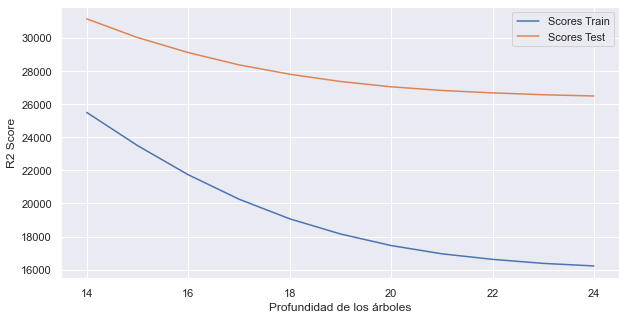

In [61]:
plt.figure(figsize=(10,5))
plt.plot(max_depths,scores_train, label = 'Scores Train')
plt.plot(max_depths,scores_test, label = 'Scores Test')
plt.legend()
plt.ylabel('R2 Score')
plt.xlabel('Profundidad de los árboles')
plt.show()

En el gráfico se ve con claridad cómo se empieza a overfittear el modelo, y que el puntaje en test no mejora significativamente luego del valor 22.
### ELECCIÓN DE MODELOS
En base a todo lo desarrollado hasta aquí, eligiría el `RandomForestRegressor`. Creo que disponemos de un dataset robusto, con muchas instancias, lo cual es una situación ideal para modelos de ensamble. De todas formas, creo que obtuvimos un muy buen resultado con la regresión `Ridge`, que si bien no fue tan buena como el bosque, si nos dió un score de 0.78. En cuanto al modelo de la primera parte, no lo considero bueno para ponerlo en producción, pero si lo consideraría como un buen modelo *benchmark*, ya que es un modelo simple, pero que con un buen preprocesamiento de los datos nos dió un score de 0.82

## INTERPRETACIÓN DE MODELOS

A continuación voy a definir los modelos nuevamente para simplificar el código, intentando analizar con más profundidad los errores, qué features son más importantes, cómo se comportan los diferentes árboles en el `RandomForestRegresor`, y otras implicancias de los modelos.

* `Ridge`

Lo primero es redefinir nuevamente los modelos para hacer las predicciones y evaluarlos en test.

In [62]:
X_reg = data[['surface_covered', 'l3', 'bathrooms']]
X_reg = poly.transform(X_reg)
y = data['price']
X_reg_train, X_reg_test, y_train, y_test = train_test_split(X_reg, y, test_size=0.3)

In [63]:
reg = Ridge()
reg.fit(X_reg_train,y_train)
y_test_pred = reg.predict(X_reg_test)
y_train_pred = reg.predict(X_reg_train)

In [64]:
print('El MAE para reg en test es: ', metrics.mean_absolute_error(y_test, y_test_pred))
print('El MAE para reg en train es: ', metrics.mean_absolute_error(y_train, y_train_pred))
print('El factor R2 para reg en test es: ', metrics.r2_score(y_test, y_test_pred))
print('El factor R2 para reg en train es: ', metrics.r2_score(y_train, y_train_pred))

El MAE para reg en test es:  47632.026510214295
El MAE para reg en train es:  46772.75122591773
El factor R2 para reg en test es:  0.7820619827137303
El factor R2 para reg en train es:  0.7786298077925499


Vemos que tenemos unas métricas similares a las que vimos al comienzo(lo cual tiene sentido considerando que el grid search no mejoraba mucho el rendimiento, su mejor puntaje era similar al inicial). En el siguiente gráfico voy a plotear la importancia de cada feature (los originales y la combinación que nos generó `PolynoialFeatures`).

<AxesSubplot:>

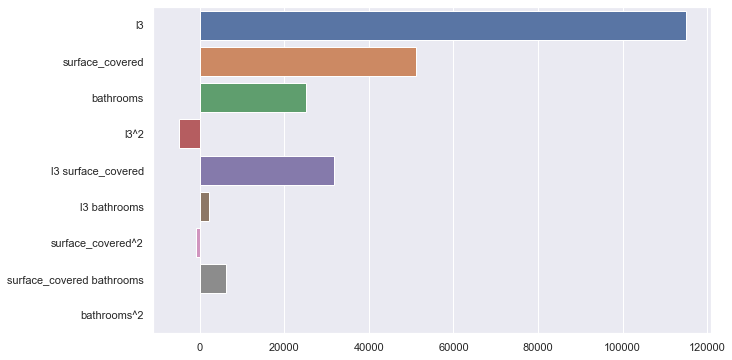

In [65]:
feature_names = poly.get_feature_names(input_features=['l3','surface_covered','bathrooms'])
importances = reg.coef_
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_names)

In [66]:
print('Coeficientes:', reg.coef_,'Ordenada al origen:', reg.intercept_)

Coeficientes: [ 1.15018732e+05  5.11868743e+04  2.50707383e+04 -4.97011783e+03
  3.18096627e+04  2.17232527e+03 -8.09691529e+02  6.23165097e+03
 -3.31083327e+01] Ordenada al origen: 226986.79815429752


En el proyecto 1, una de mis conclusiones había sido que dejar de lado la variable de ubicación era un error porque era determinante en el cálculo del precio. Este gráfico lo muestra de forma evidente. También vemos en qué medida intervienen los demás features.

Ahora quiero estudiar los errores. En un modelo que predice bien, la distribución de los errores debería ser aproximadamente normal alrededor del 0.

C:\Users\Pc\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Pc\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


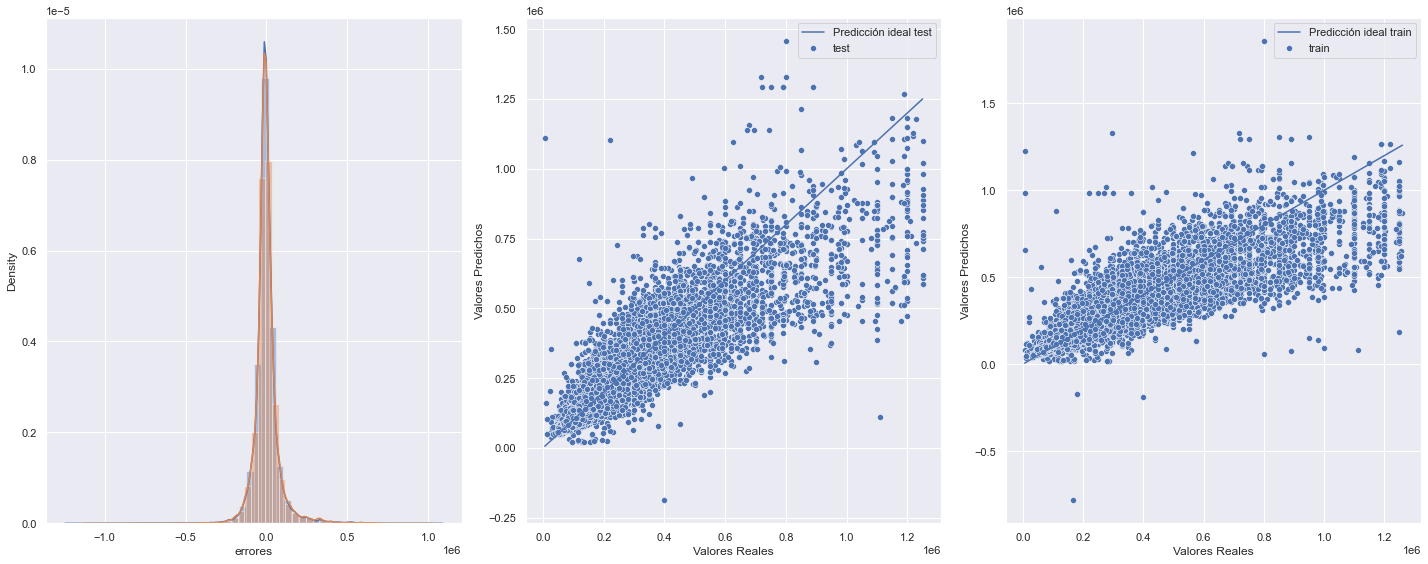

In [67]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.distplot(y_train - y_train_pred, bins = 50, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 50, label = 'test')
plt.xlabel('errores')

plt.subplot(1,3,2)
sns.scatterplot(x=y_test, y=y_test_pred, label = 'test')
sns.lineplot(x=y_test, y=y_test, label= 'Predicción ideal test')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

plt.subplot(1,3,3)
sns.scatterplot(x=y_train, y=y_train_pred, label = 'train')
sns.lineplot(x=y_train, y=y_train, label= 'Predicción ideal train')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

plt.legend()
plt.tight_layout()

Si observamos detenidamente podemos ver como los errores de test (rojo) están ligeramente por debajo de los de train (azul). Esto nos confirma que el modelo no está overfitteado.

Por otro lado, se ve en los otros dos gráficos, que tanto en train como en test, el modelo se confunde mucho más a medida que el precio de las propiedades aumenta. También podemos explicar esto mirando el gráfico. Si bien hemos preprocesado la data, aún vemos que no es un dataset totalmente balanceado, porque tenemos una franja de precio para la cual tenemos menos instancias.

Un detalle para resaltar: en los valores reales versus predichos, el modelo predijo valores negativos. Creo que esto significa que el modelo no termina de interpretar correctamente al dataset, que en definitiva es lo que buscamos en una buena predicción: **no entrenar al modelo con los datos "de memoria", si no que el mismo COMPRENDA la estructura de los datos, y no que los replique.**

Esperaba un mejor desempeño en este modelo, creí que por la correlación que existía entre algunas de las variables, un modelo lineal iba a tener un mejor desempeño.

* `RandomForestRegressor`

Volvemos a definir el modelo con los hiperparámetros elegidos y evaluamos. Luego seguimos con la interpretación.

In [68]:
X = data[['l3','rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered','Casa','Departamento','PH']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
forest = RandomForestRegressor(n_estimators=300, max_depth=22, max_features=2, oob_score=True, max_samples=0.7)
forest.fit(X_train, y_train)
y_test_pred = forest.predict(X_test)
y_train_pred = forest.predict(X_train)

In [69]:
print('El MAE para forest en test es: ', metrics.mean_absolute_error(y_test, y_test_pred))
print('El MAE para forest en train es: ', metrics.mean_absolute_error(y_train, y_train_pred))
print('El factor R2 para forest en test es: ', metrics.r2_score(y_test, y_test_pred))
print('El factor R2 para forest en train es: ', metrics.r2_score(y_train, y_train_pred))

El MAE para forest en test es:  26546.500178795442
El MAE para forest en train es:  16808.44463789288
El factor R2 para forest en test es:  0.9025438228474703
El factor R2 para forest en train es:  0.9663812220140447


Si bien se ve que el MAE es un poco más alto que el que tuvimos inicialmente, esto se debe a que para poder reducir el overfitting tenemos que sacrificar algo de puntaje en train. Conseguimos reducir la diferencia de MAE entre train y test en un 10% aproximadamente.

Ahora vamos a graficar la importancia de cada feature a la hora de entrenar el modelo.

<AxesSubplot:>

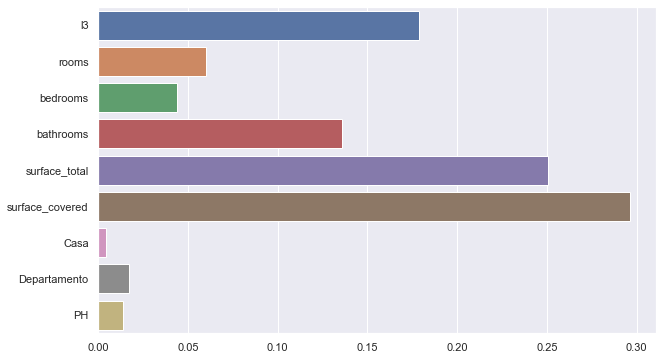

In [70]:
importances = forest.feature_importances_
names = X.columns
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=names)

Como muestra el gráfico, las variables predictoras por excelencia son las de superficie y la ubicación. También podemos ver como el modelo aprovecha todos los features para hacer las predicciones, incluso las variables dummies (aunque en menor medida)

Ahora vamos a visualizar las importancias que le dan algunos árboles particulares a cada feature.

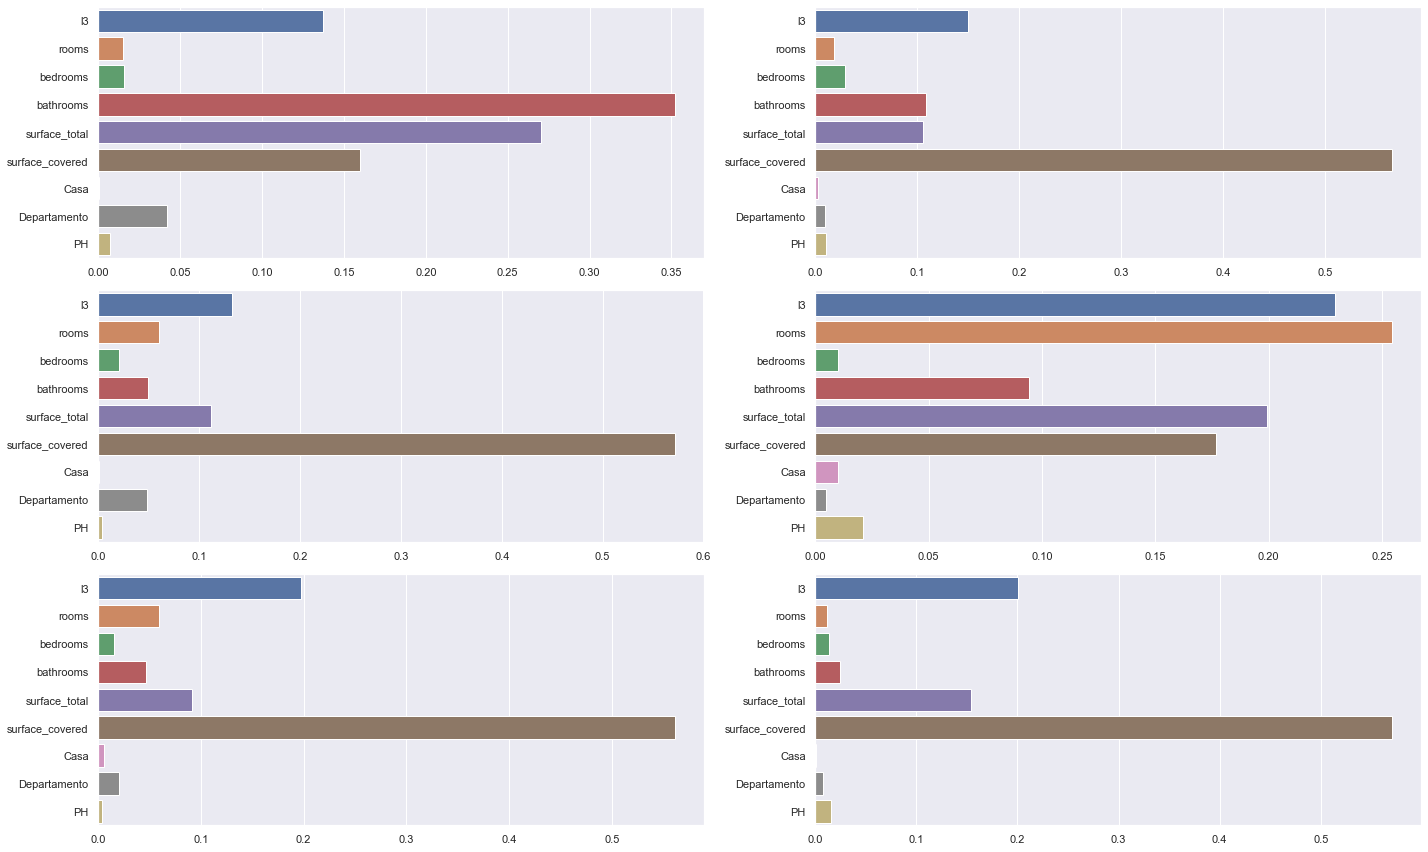

In [71]:
trees= [15,40,58,73,115,130] #ELIJO 6 ARBOLES AL AZAR
plt.figure(figsize=(20,12))
for i,t in enumerate(trees):
  plt.subplot(3,2,i+1)
  tree = forest.estimators_[t]
  importances = tree.feature_importances_
  names = X.columns
  sns.barplot(x=importances, y=names)

plt.tight_layout()
plt.show()

Lo que vemos en el gráfico es consecuencia de ajustar el parámetro `max_features`, en este caso lo fijé en 2, para que los árboles consideren diferentes features a la hora de hacer los entrenamientos. Podemos destacar como este modelo es capaz de trabajar aprovechando al máximo todas las columnas e instancias de nuestro dataset.

Lo siguiente es graficar los errores y los valores predichos versus los valores reales.

C:\Users\Pc\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Pc\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


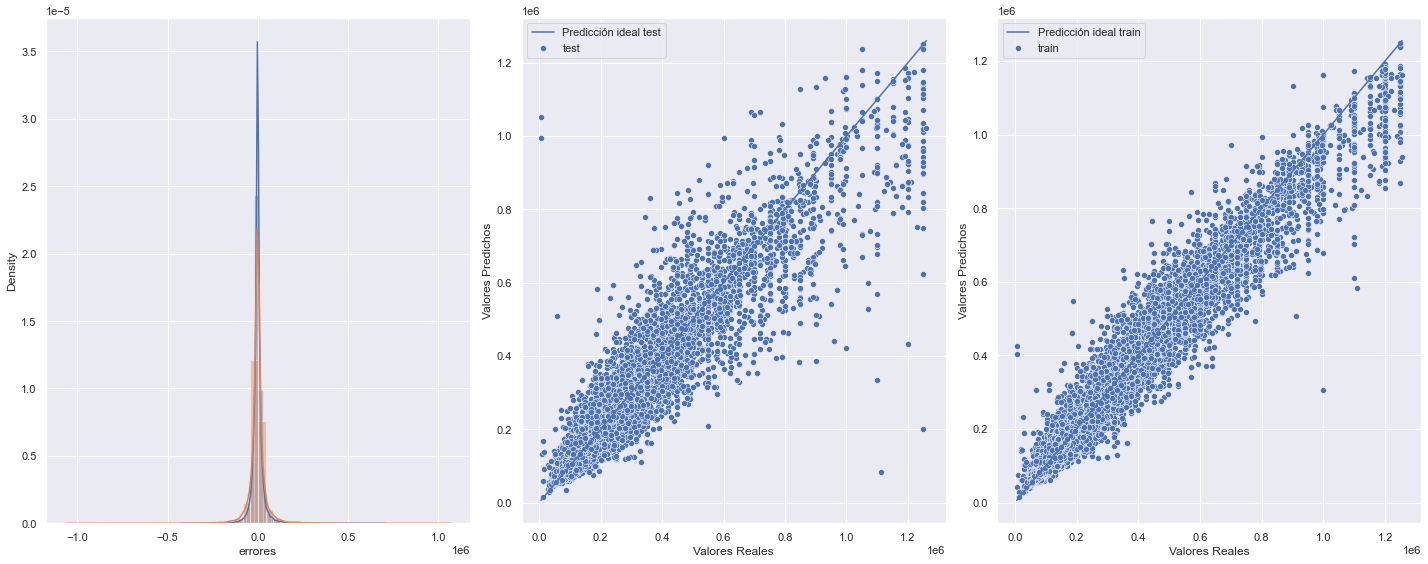

In [72]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.distplot(y_train - y_train_pred, bins = 50, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 50, label = 'test')
plt.xlabel('errores')

plt.subplot(1,3,2)
sns.scatterplot(x=y_test, y=y_test_pred, label = 'test')
sns.lineplot(x=y_test, y=y_test, label= 'Predicción ideal test')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

plt.subplot(1,3,3)
sns.scatterplot(x=y_train, y=y_train_pred, label = 'train')
sns.lineplot(x=y_train, y=y_train, label= 'Predicción ideal train')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

plt.legend()
plt.tight_layout()

En comparación con los gráficos para el modelo de regresión, tenemos unos gráficos excelentes. En este caso, haciendo énfasis en el gráfico valores reales versus valores predichos, el modelo acierta mucho más. Los errores en este caso también están en torno a las propiedades más caras (las cuales tiende a tasar por **debajo** de su valor real), lo cual refuerza la teoría de que el dataset está desbalanceado. Creo que este modelo supo explicar mejor de que forma se comportan los datos. En cuanto a la distribución de errores también vemos que está incluso más centrada que en la regresión lineal.

En contraposición con el modelo lineal, este ensamble sí cumplió con las expectativas que tenía, ya que ajustando algunos parámetros el modelo supo iterar entre features y aprovecho al máximo las características de este dataset.

## CONCLUSIONES

Algunos conceptos principales a destacar luego del desarrollo de este nuevo proyecto:
* **El preprocesamiento de datos es la técnica que mejora el rendimiento de los modelos en mayor medida**
* **Los modelos de ensamble nos dan buenos resultados con datasets robustos (muchas columnas y muchas instancias**
* **Si no tenemos un dataset balanceado, los modelos podrían confundirse con las instancias menos comunes**

Dicho esto, me quedaría con el modelo `RandomForestRegressor`, que creo que tiene muy buenos resultados y que con un dataset más balanceado, estos podrían mejorarse aún mas. Tal vez hacer por segunda vez la regla de las 3 sigmas para la detección de outliers, y quedarnos con un conjunto de datos más uniforme.

En cuanto a las implicancias particulares de este dataset, la inclusión de la variable de ubicación en el entrenamiento tiene mucho que ver con el alto rendimiento que conseguimos en el random forest.

Debo admitir que el desempeño de los modelos (en especial el forest) superó mis expectativas. Es destacable el rendimiento que uno puede conseguir entendiendo con más detalle cómo trabajan los modelos, y adaptando la estructura de datos de acuerdo a lo que el modelo necesita.

## ADICIONAL - CLUSTERING

A continuación vamos a probar un algortitmo K-means, para ver si con las variables `price` y `surface_covered`, que como vimos a lo largo del desarrollo de ambos proyectos, están relacionadas y son las que mejor identifican a las propiedades entre sí.

En el gráfico siguiente voy a plotear con `lat` y `lon` para visualizar fácilmente los diferentes barrios, y como anteriormente codificamos usando el valor por metro cuadrado, estarán más grandes y oscuros los barrios más caros, y más claros y pequeños los barrios más baratos.

Primero voy a tirar las filas con valores faltantes de `lat` y `lon`.

In [73]:
data.dropna(subset=['lat','lon'], inplace=True)
data.reset_index(drop=True, inplace=True)

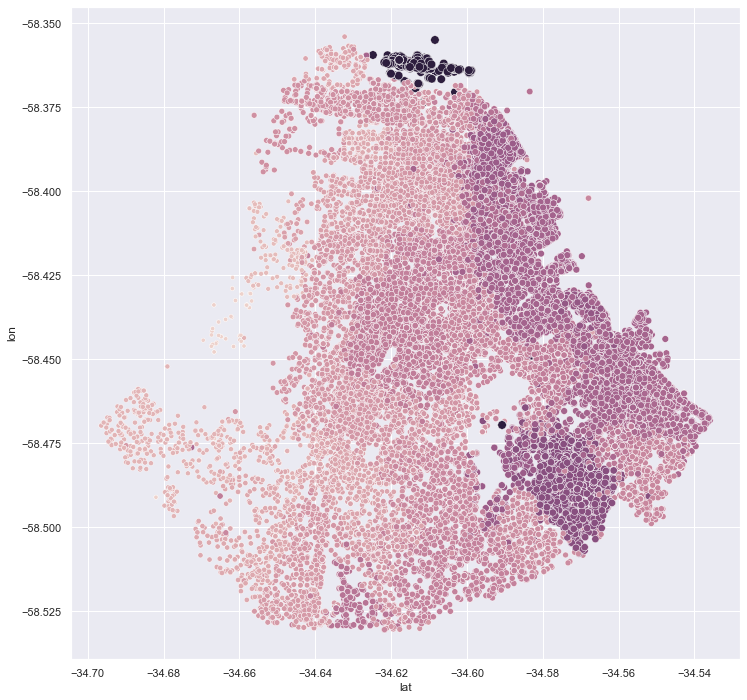

In [74]:
plt.figure(figsize=(12,12))
g = sns.scatterplot(x=data.lat, y=data.lon, hue=data.l3, size=data.l3)
g.legend_.remove()

Aquí podemos visualizar fácilmente como están dispuestos los barrios de la ciudad de Buenos Aires, pero la ubicación no nos dice nada por sí sola, necesitamos variables predictoras que aporten información al modelo. Vamos a graficar entonces `price` y `surface_covered`, que son las variables que le vamos a pasar al modelo. Primero voy a escalar la variable `price`, que ahora dejará de ser *target* para ser *feature*.

**Nota:** notar que uso como `hue` en este caso los barrios que ya tenemos, que son obviamente una división arbitraria que tiene la Ciudad de Buenos Aires, pero que sí infiere en el precio de una propiedad. Lo que queremos observar ahora es que tanto se acerca el algoritmo a emular esas regiones.

In [75]:
scaler = StandardScaler()
scaler.fit(data[['price']])
data['price'] = scaler.transform(data[['price']])

<AxesSubplot:xlabel='surface_covered', ylabel='price'>

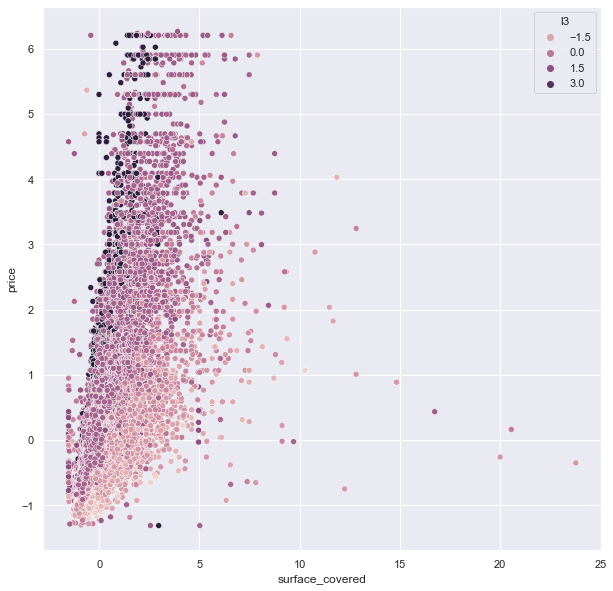

In [76]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=data.surface_covered, y=data.price, hue=data.l3)

Vamos a definir las variables para pasarle al modelo, importamos el algoritmo correspondiente, entrenamos y finalmente voy a volver a plotear con las etiquetas que el modelo encuentre

In [77]:
X=data[['price','surface_covered']]

In [78]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

Si bien tenemos muchos más barrios que sólo 5, estos están definidos arbitrariamente, y acá vamos a intentar que el modelo encuentre 5 *rangos* de precio en función de la superficie cubierta.

In [79]:
etiquetas = kmeans.labels_
centros = kmeans.cluster_centers_

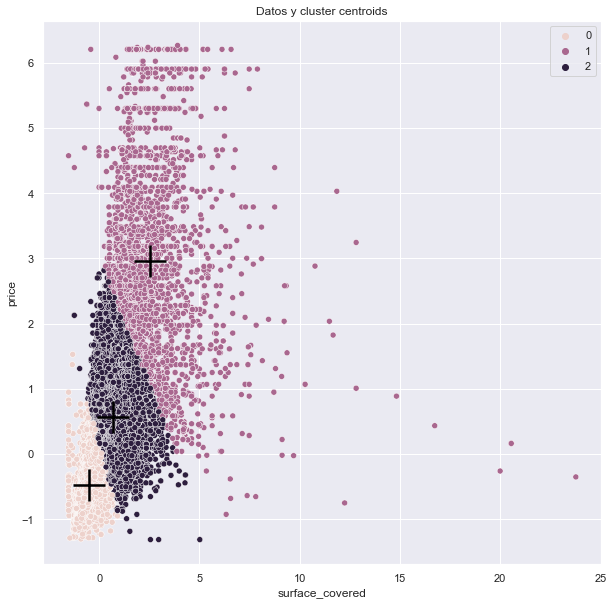

In [80]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=X.iloc[:, 1], y=X.iloc[:, 0], hue = etiquetas)
sns.scatterplot(x=centros[:, 1], y=centros[:, 0],color='black', marker="+", s=1000)
plt.title('Datos y cluster centroids')
plt.show()

<AxesSubplot:xlabel='lat', ylabel='lon'>

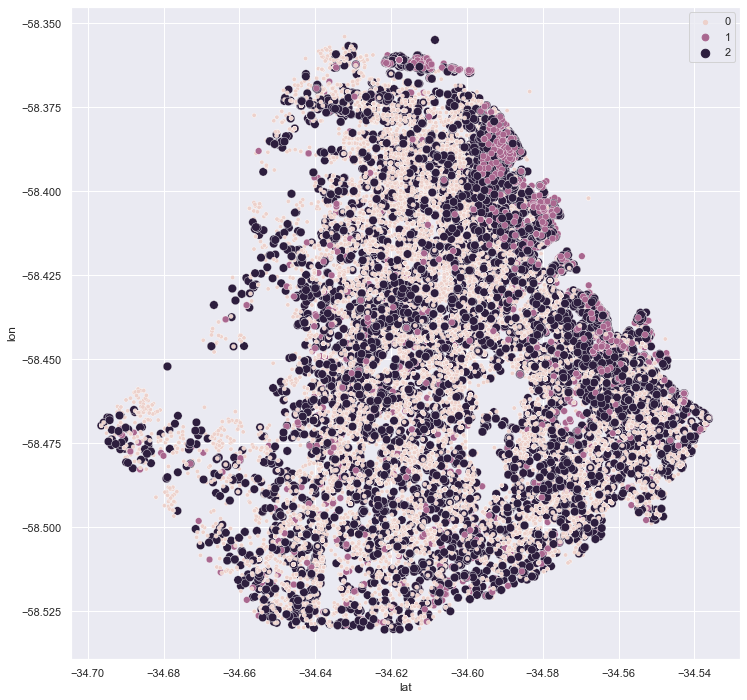

In [81]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=data.lat, y=data.lon, hue=etiquetas, size=etiquetas)

Analizando ambos gráficos vemos que el algoritmo se enfocó mucho más en el precio de las propiedades, que en la superficie cubierta. Tal vez para un mejor funcionamiento del algoritmo, sería mejor pasarle la variable `m2` y alguna otra variable continua (en este caso solo teníamos `surface_total` como variable continua, pero esta no se puede considerar independiente de `surface_covered`). No es una aproximación como la que esperaba.